In [1]:
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
from config import PROJECT_DIR, VOC_CLASSES, LABELS_DIR, TRUE_LABELS_CSV, RESULTS_DIR, HISTORIES_DIR, FIGURES_DIR
from experiment_config import experiments
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

plt.style.use('default')
experiment_count = sum(len(experiments[exp]) for exp in experiments)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [2]:
# Load all experiment results into a single dataframe

all_results = pd.DataFrame()
for file_path in RESULTS_DIR.glob("*.csv"):
    exp_title = file_path.stem
    df = pd.read_csv(file_path)
    df['experiment_set'] = exp_title
    all_results = pd.concat([all_results, df], ignore_index=True)
all_results.sort_values(by='id', inplace=True)
all_results.reset_index(drop=True, inplace=True)
assert len(all_results) == experiment_count

In [3]:
best_model_id = all_results.loc[all_results['test_map'].idxmax()]['id']
all_results.loc[best_model_id]

id                            26
title                  optimized
test_loss               0.121245
test_acc                0.937914
test_f1                 0.800962
test_map                0.917229
test_subset_acc         0.625584
train_loss              0.005233
train_acc               0.999958
train_f1                0.994401
train_map               0.999179
train_subset_acc        0.982598
train_time          12574.638393
experiment_set         optimized
Name: 26, dtype: object

In [4]:
# Load all history files into a list of dataframes
histories = []
for history_file in sorted(HISTORIES_DIR.glob("*.csv")):
    df = pd.read_csv(history_file)
    histories.append(df)
assert len(histories) == experiment_count

In [5]:
# Load all prediction files into a list of dataframes
predictions = []
for pred_file in sorted(LABELS_DIR.glob("*.csv")):
    if pred_file == TRUE_LABELS_CSV:
        continue
    df = pd.read_csv(pred_file)
    predictions.append(df)
assert len(predictions) == experiment_count

In [6]:
TEST_JSON = PROJECT_DIR / "data" / "preprocessed_jsons" / "test.json"

# Load test data
with open(TEST_JSON) as f:
    test_data = json.load(f)

# Process data to match the format of predicted.csv
true_labels_list = []
for item in test_data:
    image_name = item['file_path']
    labels = [0] * 20  # Assuming 20 possible labels
    for obj in item['object_labels']:
        label_index = VOC_CLASSES[obj['name']]
        labels[label_index] = 1
    true_labels_list.append([image_name] + labels)
    
# Create a DataFrame
true_labels_df = pd.DataFrame(true_labels_list, columns=['image_name'] + [str(i) for i in range(20)])

# Save to CSV
true_labels_df.to_csv(TRUE_LABELS_CSV, index=False)

In [7]:
heatmap_params = {
    'annot': True, 
    'fmt': '.3f',
    'cmap': 'RdYlGn',
    'vmin': 0.5,
    'vmax': 0.95
}

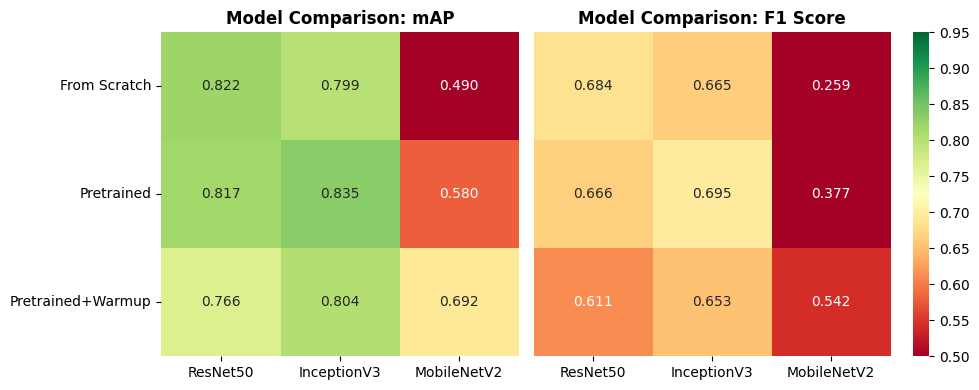

In [8]:
# Load model performance data
model_performance = all_results[all_results['experiment_set'] == 'model-experiments']

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
metric_display_names = {
    'test_map': 'mAP',
    'test_f1': 'F1 Score'
}
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.25]})

for idx, metric in enumerate(metrics):
    # Reshape data into matrix form
    data_matrix = np.zeros((3, 3))  # 3 training setups x 3 model types
    
    # Fill matrix with metric values
    for i, setup in enumerate(['no-pretraining no-warmup', ' pretraining no-warmup', 'pretraining warmup']):
        for j, model in enumerate(['resnet50', 'inception_v3', 'mobilenet_v2']):
            idx_model = model_performance[model_performance['title'].str.contains(model) & 
                                  model_performance['title'].str.contains(setup)].index[0]
            data_matrix[i,j] = model_performance.loc[idx_model, metric]

    sns.heatmap(data_matrix, 
                xticklabels=['ResNet50', 'InceptionV3', 'MobileNetV2'],
                yticklabels=['From Scratch', 'Pretrained', 'Pretrained+Warmup'] if idx == 0 else False,
                ax=axes[idx],
                **heatmap_params,
                cbar= idx == len(metrics)-1)
    axes[idx].set_title(f'Model Comparison: {metric_display_names[metric]}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_comparison_heatmap.png")
plt.show()

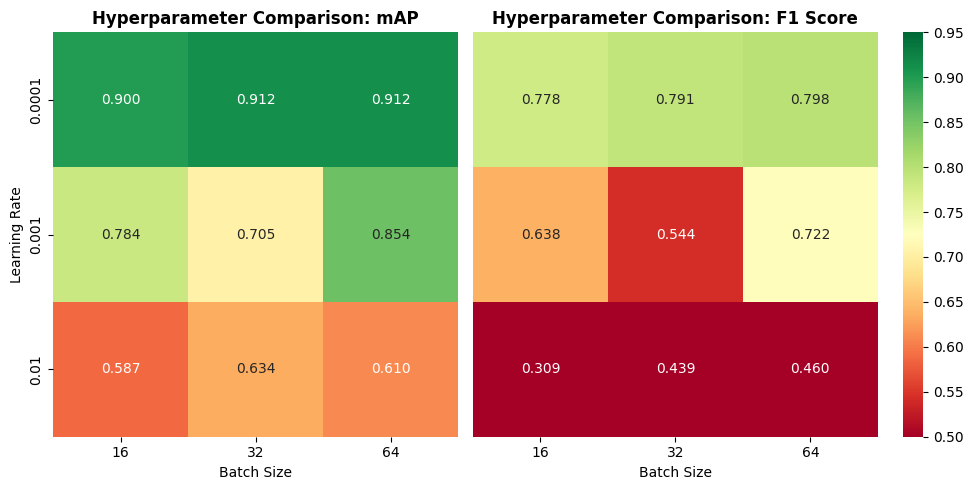

In [9]:
# Load hyperparameter performance data
hyperparameter_performance = all_results[all_results['experiment_set'] == 'hyperparameter-experiments']

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
metric_display_names = {
    'test_map': 'mAP',
    'test_f1': 'F1 Score'
}
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1.25]})

for idx, metric in enumerate(metrics):
    # Reshape data into matrix form
    data_matrix = np.zeros((3, 3))  # 3 learning rates x 3 batch sizes
    
    # Fill matrix with metric values
    for i, lr in enumerate([0.0001, 0.001, 0.01]):
        for j, bs in enumerate([16, 32, 64]):
            idx_model = hyperparameter_performance[
                hyperparameter_performance['title'].str.contains(f'batch_size={bs}') & 
                hyperparameter_performance['title'].str.contains(f'learning_rate={lr}')
            ].index[0]
            data_matrix[i,j] = hyperparameter_performance.loc[idx_model, metric]

    sns.heatmap(data_matrix, 
                xticklabels=['16', '32', '64'],
                yticklabels=['0.0001', '0.001', '0.01'] if idx == 0 else False,
                ax=axes[idx],
                **heatmap_params,
                cbar= idx == len(metrics)-1)
    axes[idx].set_title(f'Hyperparameter Comparison: {metric_display_names[metric]}', fontsize=12, fontweight='bold')
    if idx == 0:
        axes[idx].set_ylabel('Learning Rate')
    axes[idx].set_xlabel('Batch Size')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "hyperparameter_comparison_heatmap.png")
plt.show()

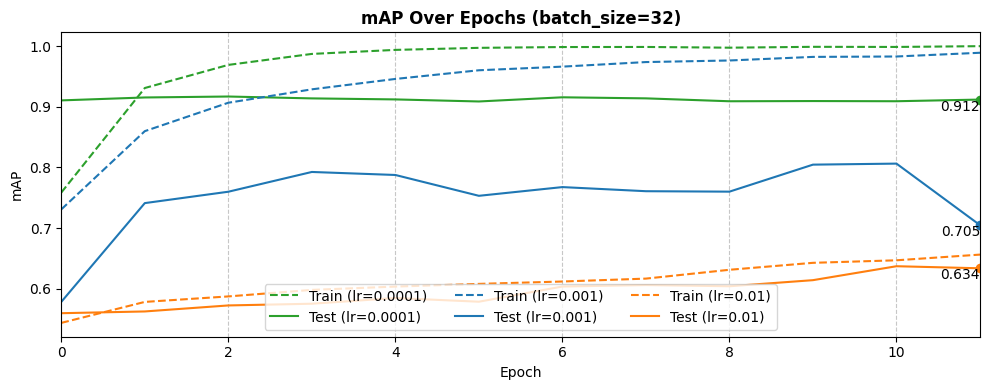

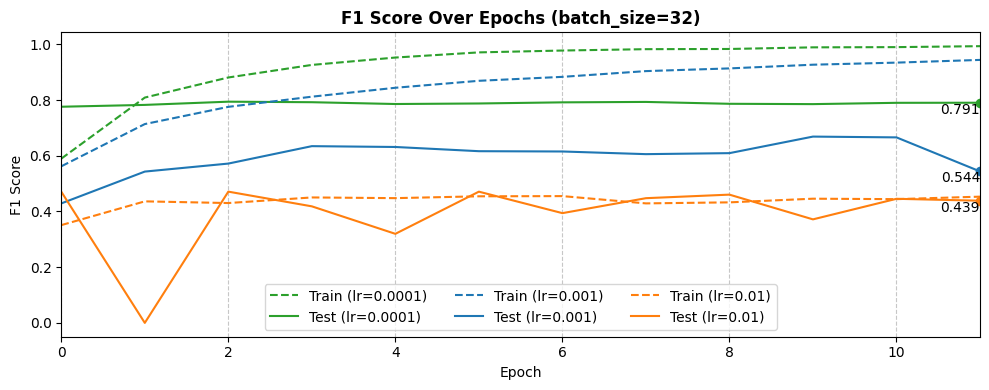

In [10]:
# Get best batch size based on test_map
best_batch_size = hyperparameter_performance.groupby('title').agg({'test_map': 'mean'}).idxmax()['test_map']
best_batch_size = int(best_batch_size.split('=')[1].split(',')[0])

# Plot learning curves for both metrics
metrics = [
    {'name': 'map', 'display': 'mAP'},
    {'name': 'f1', 'display': 'F1 Score'}
]
colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

for metric in metrics:
    plt.figure(figsize=(10, 4))
    
    for i, lr in enumerate([0.0001, 0.001, 0.01]):
        model_id = hyperparameter_performance[
            hyperparameter_performance['title'].str.contains(f'batch_size={best_batch_size}') & 
            hyperparameter_performance['title'].str.contains(f'learning_rate={lr}')
        ].iloc[0]['id']
        
        history = histories[model_id]
        
        train_col = f'train_{metric["name"]}'
        test_col = f'test_{metric["name"]}'
        
        plt.plot(history[train_col], label=f'Train (lr={lr})', linestyle='--', color=colors[i])
        plt.plot(history[test_col], label=f'Test (lr={lr})', linestyle='-', color=colors[i])

        final_value = history[test_col].iloc[-1]
        plt.scatter(len(history[test_col])-1, final_value, color=colors[i], marker='o')
        plt.text(len(history[test_col])-1, final_value, f'{final_value:.3f}', 
                verticalalignment='top',
                horizontalalignment='right')

    plt.title(f'{metric["display"]} Over Epochs (batch_size={best_batch_size})', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(metric["display"])
    plt.xlim(0, 11)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(loc='lower center', ncol=3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"learning_rate_{metric['name']}_learning_curves.png")
    plt.show()


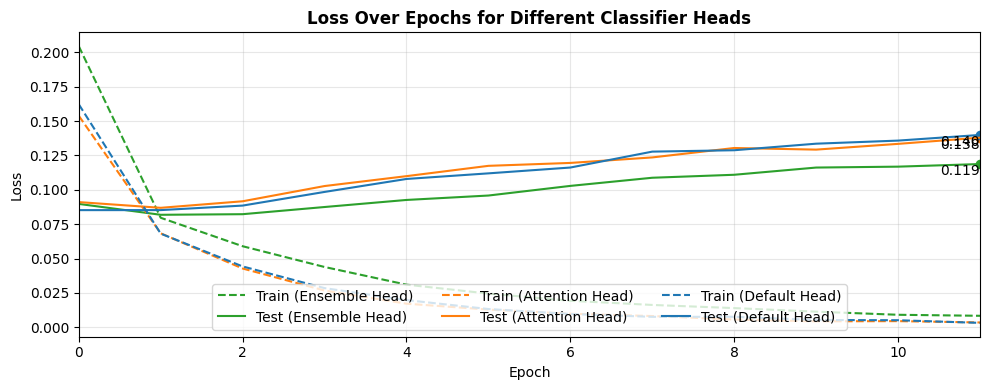

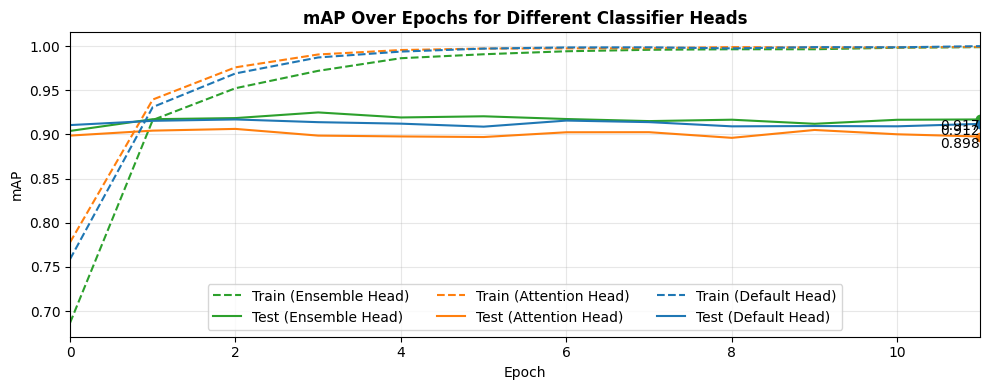

In [11]:
# Load performance data for classifier head experiments
classifier_head_performance_path = RESULTS_DIR / "classifier_head-experiments.csv"
classifier_head_performance = pd.read_csv(classifier_head_performance_path)

# Get best hyperparameter config
best_hyperparameter_id = hyperparameter_performance['test_map'].idxmax()
best_hyperparameter_config = hyperparameter_performance.loc[best_hyperparameter_id, 'title']

# Define configurations to plot
configs = [
    {
        'id': classifier_head_performance[classifier_head_performance['title'].str.contains('ensemble')].iloc[0]['id'],
        'title': 'classifier_head=ensemble',
        'label': 'Ensemble Head'
    },
    {
        'id': classifier_head_performance[classifier_head_performance['title'].str.contains('attention')].iloc[0]['id'],
        'title': 'classifier_head=attention', 
        'label': 'Attention Head'
    },
    {
        'id': best_hyperparameter_id,
        'title': best_hyperparameter_config,
        'label': 'Default Head'
    }
]
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']
metrics = ['loss', 'map']
metric_display_names = {
    'loss': 'Loss',
    'map': 'mAP'
}

for metric in metrics:
    plt.figure(figsize=(10, 4))
    # Plot each configuration
    for i, config in enumerate(configs):
        history = histories[config['id']]
        plt.plot(history[f'train_{metric}'], label=f'Train ({config["label"]})', linestyle='--', color=colors[i])
        plt.plot(history[f'test_{metric}'], label=f'Test ({config["label"]})', linestyle='-', color=colors[i])
        # Add text labels for final test values
        final_value = history[f'test_{metric}'].iloc[-1]
        plt.scatter(len(history[f'test_{metric}'])-1, final_value, color=colors[i], marker='o')
        plt.text(len(history[f'test_{metric}'])-1, final_value, f'{final_value:.3f}', 
                verticalalignment='top',
                horizontalalignment='right')

    plt.title(f'{metric_display_names[metric]} Over Epochs for Different Classifier Heads', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(metric_display_names[metric])
    plt.xlim(0, 11)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower center', ncol=3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"classifier_head_{metric}_learning_curves.png")
plt.show()

In [12]:
# Initialize list to store stats for each prediction
prediction_stats = []

# Calculate stats for each prediction dataframe
for predicted_labels_df in predictions:
    # Get images which are present in both predicted and true labels
    present_in_both = set(predicted_labels_df['image_name']) & set(true_labels_df['image_name'])

    # Calculate false positives and false negatives
    predicted = predicted_labels_df[predicted_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]
    true = true_labels_df[true_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]

    false_positives = ((predicted == 1) & (true == 0)).sum()
    false_negatives = ((predicted == 0) & (true == 1)).sum()
    true_positives = ((predicted == 1) & (true == 1)).sum()
    true_negatives = ((predicted == 0) & (true == 0)).sum()

    # Generate a table of the false positives and negatives for each label
    stats_table = pd.DataFrame({
        'Label': VOC_CLASSES.keys(),
        'False Positives': false_positives,
        'False Negatives': false_negatives,
        'True Positives': true_positives,
        'True Negatives': true_negatives,
        'Accuracy': (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives),
        'Precision': true_positives / (true_positives + false_positives),
        'Recall': true_positives / (true_positives + false_negatives),
        'F1 Score': 2 * (true_positives / (true_positives + false_positives)) * (true_positives / (true_positives + false_negatives)) / ((true_positives / (true_positives + false_positives)) + (true_positives / (true_positives + false_negatives))),
        'TP Rate': true_positives / (true_positives + false_negatives),
        'TN Rate': true_negatives / (true_negatives + false_positives),
        'FP Rate': false_positives / (true_positives + false_positives),
        'FN Rate': false_negatives / (true_negatives + false_negatives)
    })
    stats_table.sort_values(by='F1 Score', ascending=False, inplace=True)
    
    # Store all stats in a dictionary
    prediction_stats.append({
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_positives': true_positives,
        'true_negatives': true_negatives,
        'stats_table': stats_table
    })

# Display stats table for first prediction (to maintain original output)
prediction_stats[0]['stats_table']

,Label,False Positives,False Negatives,True Positives,True Negatives,Accuracy,Precision,Recall,F1 Score,TP Rate,TN Rate,FP Rate,FN Rate
14,person,791,653,1248,732,0.578271,0.612065,0.656497,0.633503,0.656497,0.480630,0.387935,0.471480
11,dog,146,257,17,3004,0.882301,0.104294,0.062044,0.077803,0.062044,0.953651,0.895706,0.078810
0,aeroplane,93,133,9,3189,0.933995,0.088235,0.063380,0.073770,0.063380,0.971664,0.911765,0.040036
7,cat,149,223,14,3038,0.891355,0.085890,0.059072,0.070000,0.059072,0.953248,0.914110,0.068384
6,car,115,250,12,3047,0.893400,0.094488,0.045802,0.061697,0.045802,0.963631,0.905512,0.075827
15,pottedplant,193,108,9,3114,0.912091,0.044554,0.076923,0.056426,0.076923,0.941639,0.955446,0.033520
4,bottle,77,164,5,3178,0.929614,0.060976,0.029586,0.039841,0.029586,0.976344,0.939024,0.049072
17,sofa,91,164,5,3164,0.925526,0.052083,0.029586,0.037736,0.029586,0.972043,0.947917,0.049279
8,chair,103,266,7,3048,0.892231,0.063636,0.025641,0.036554,0.025641,0.967312,0.936364,0.080266
5,bus,58,102,3,3261,0.953271,0.049180,0.028571,0.036145,0.028571,0.982525,0.950820,0.030330


In [13]:
# Group by experiment_set and find best model (highest test_map) for each set
best_models = all_results.groupby('experiment_set')['test_map'].idxmax()

# Convert to dictionary for easy access
best_model_ids = best_models.to_dict()
best_model_ids

{'augmentation-experiments': 20,
 'classifier_head-experiments': 18,
 'hyperparameter-experiments': 12,
 'imbalance-experiments': 25,
 'model-experiments': 4,
 'optimized': 26}

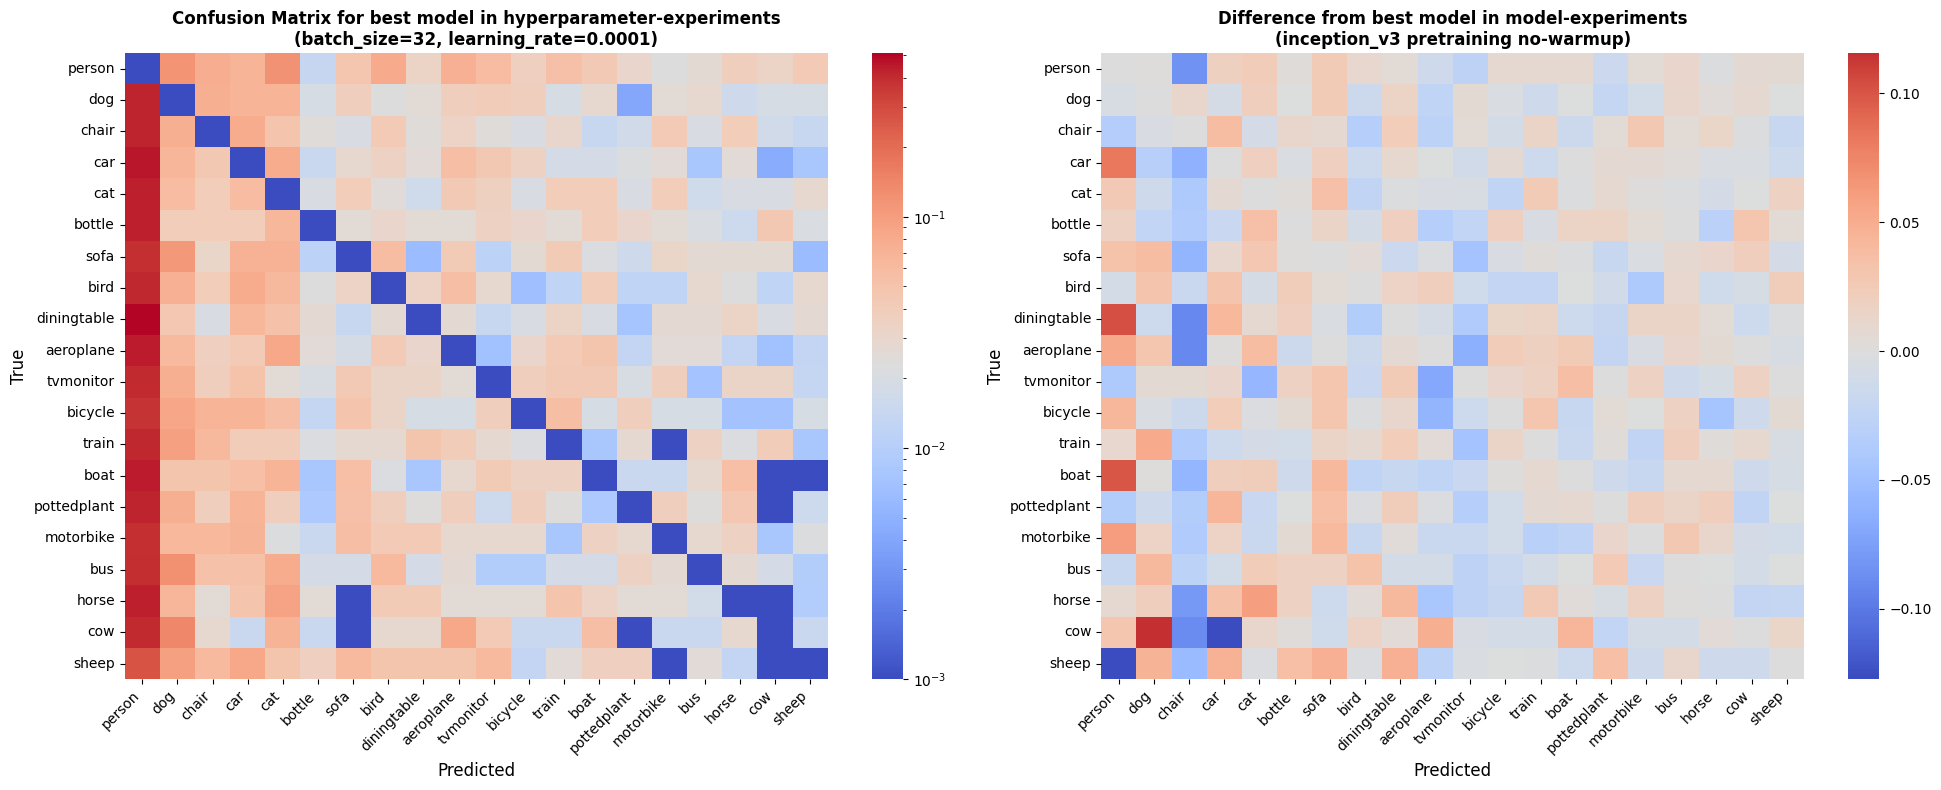

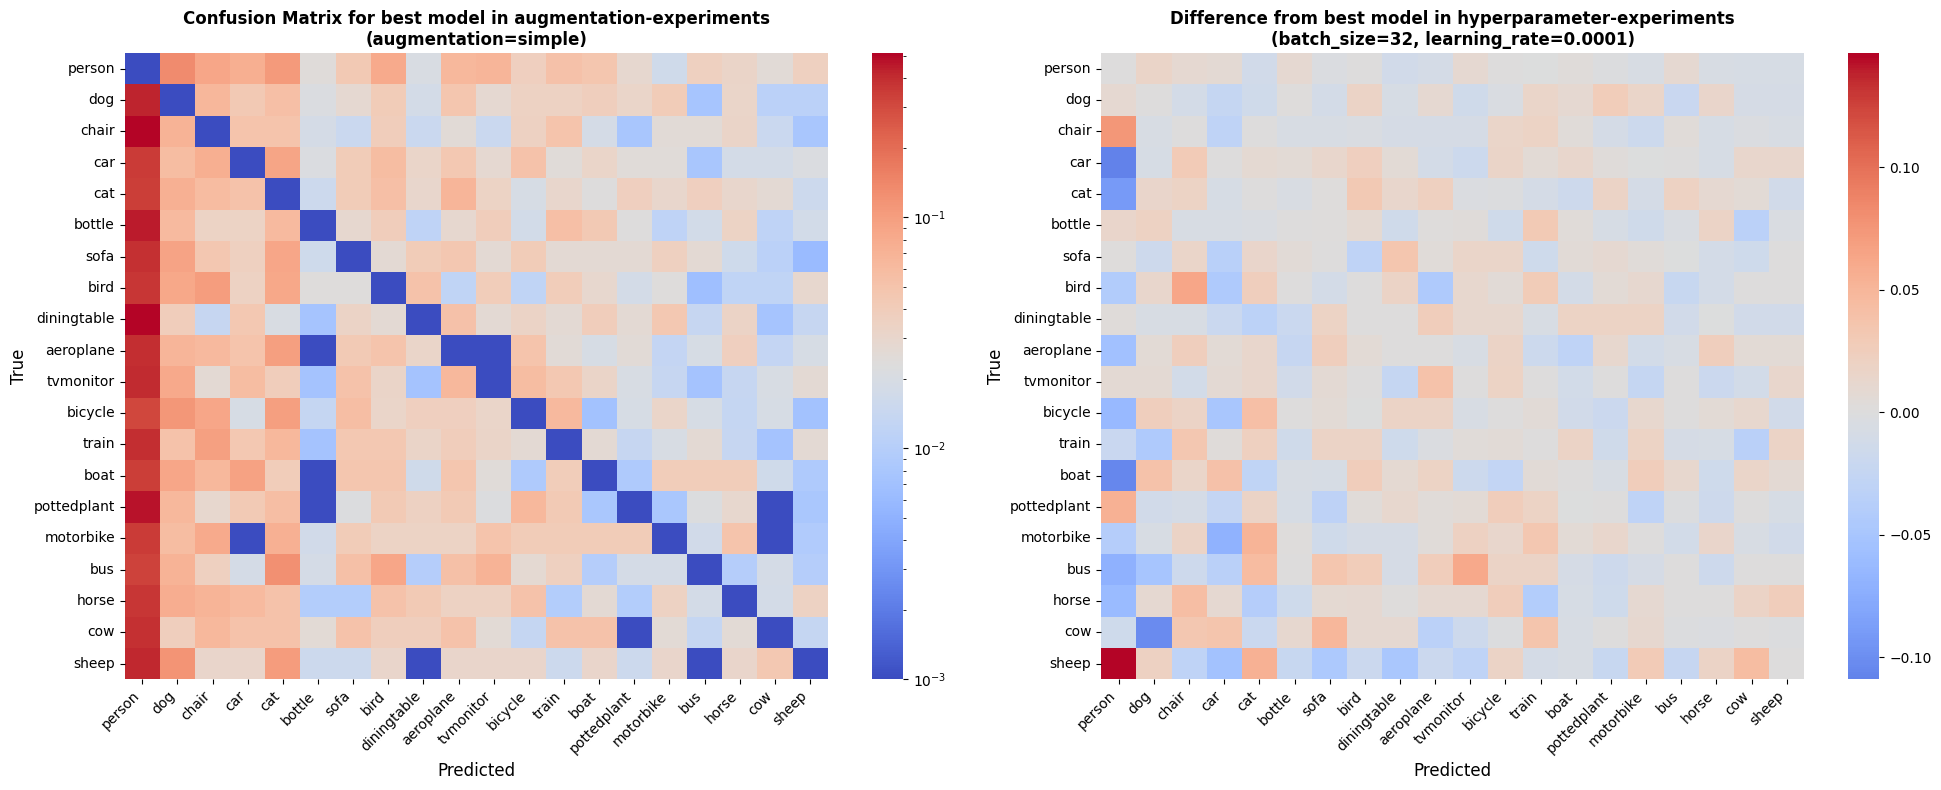

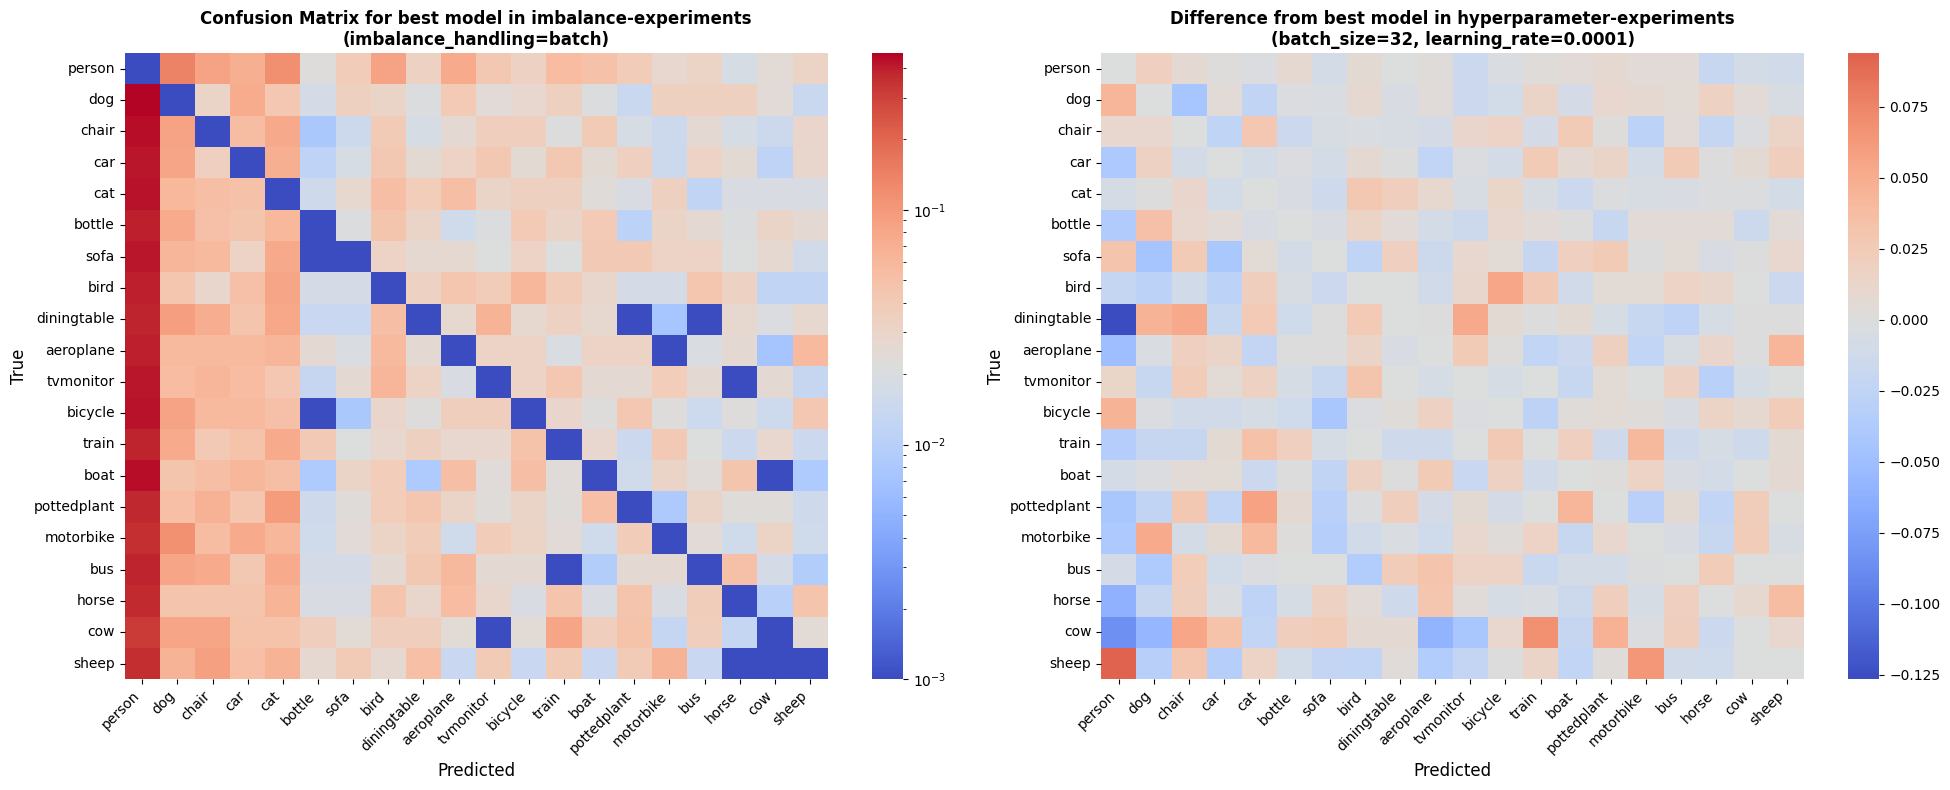

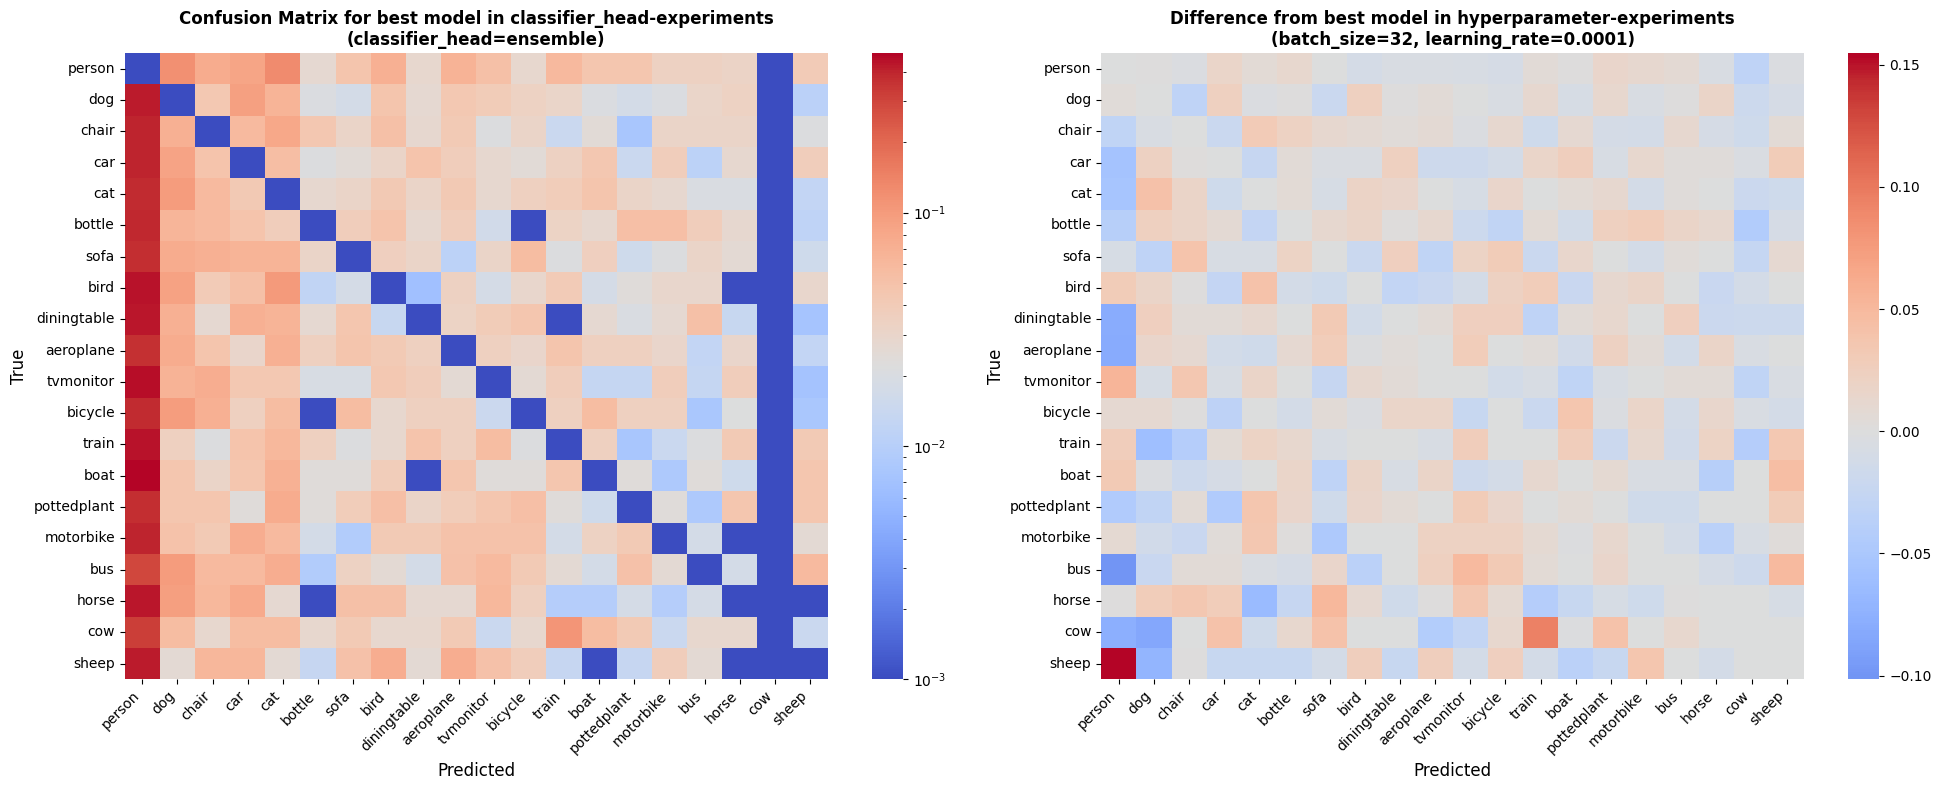

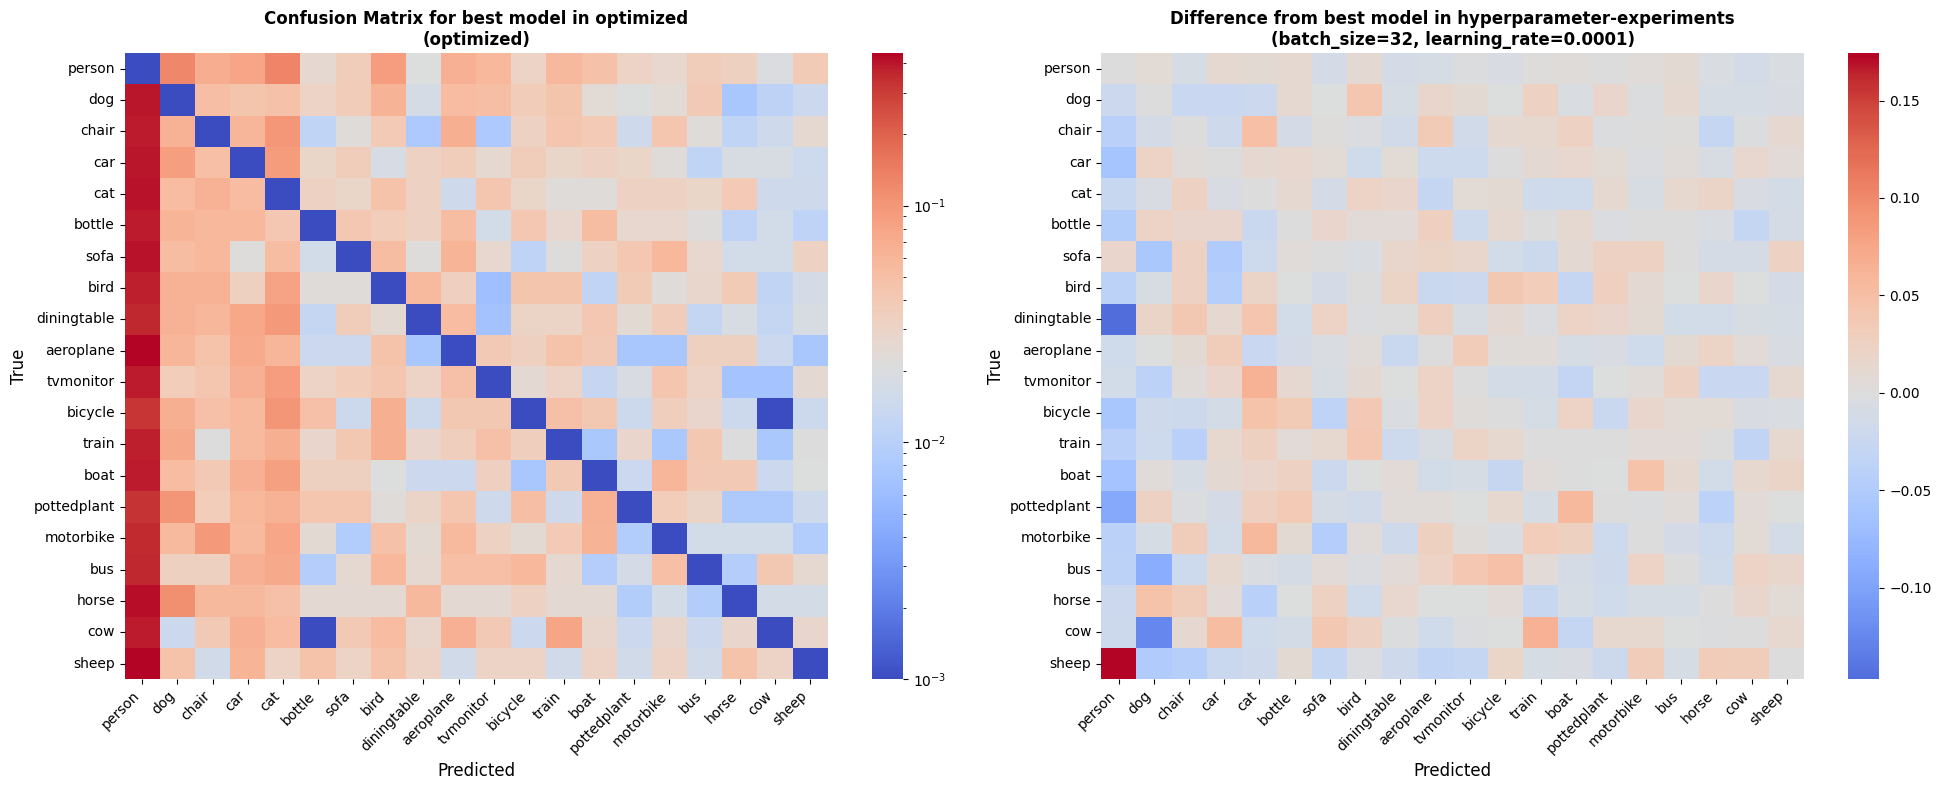

In [14]:
labels_in_order_of_true_positives = sorted(list(VOC_CLASSES.keys()), key=lambda x: true_labels_df[str(VOC_CLASSES[x])].sum(), reverse=True)

# Function to create confusion matrix for a model
def create_confusion_matrix(true, predicted):
    num_labels = true.shape[1]
    label_confusion_matrix = np.zeros((num_labels, num_labels), dtype=int)
    
    # Populate the confusion matrix
    for i in range(len(true)):
        true_labels = np.where(true.iloc[i] == 1)[0]
        predicted_labels = np.where(predicted.iloc[i] == 1)[0]
        
        for t in true_labels:
            if t not in predicted_labels:
                for p in predicted_labels:
                    label_confusion_matrix[t, p] += 1
                    
    # Convert to DataFrame
    confusion_df = pd.DataFrame(label_confusion_matrix, 
                              index=VOC_CLASSES.keys(),
                              columns=VOC_CLASSES.keys())
    confusion_df = confusion_df.loc[labels_in_order_of_true_positives, labels_in_order_of_true_positives]
    
    # Normalize and add small constant to avoid log(0)
    confusion_df_norm = confusion_df.div(confusion_df.sum(axis=1), axis=0)
    confusion_df_norm += 0.001
    
    return confusion_df_norm

# Sort models by experiment ID

comparison_pairs = [('model-experiments', 'hyperparameter-experiments'),
                    ('hyperparameter-experiments', 'augmentation-experiments'),
                    ('hyperparameter-experiments', 'imbalance-experiments'),
                    ('hyperparameter-experiments', 'classifier_head-experiments'),
                    ('hyperparameter-experiments', 'optimized')]

# Iterate through models in order
for prev_exp_set, curr_exp_set in comparison_pairs:
    curr_model_id = best_model_ids[curr_exp_set]
    prev_model_id = best_model_ids[prev_exp_set]
    # Get predictions for current and previous model
    curr_predictions = predictions[curr_model_id].iloc[:, 1:]
    prev_predictions = predictions[prev_model_id].iloc[:, 1:]
    
    # Create confusion matrices
    curr_conf = create_confusion_matrix(true, curr_predictions)
    prev_conf = create_confusion_matrix(true, prev_predictions)
    
    # Calculate difference
    diff_conf = curr_conf - prev_conf
    
    # Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Current model confusion matrix
    sns.heatmap(curr_conf,
                xticklabels=curr_conf.columns,
                yticklabels=curr_conf.columns,
                norm=LogNorm(),
                cmap='coolwarm',
                ax=ax1)
    ax1.set_xticklabels(curr_conf.columns, rotation=45, ha='right')
    ax1.set_title(f'Confusion Matrix for best model in {curr_exp_set}\n({all_results.loc[curr_model_id]["title"]})',
                    fontsize=12, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=12)
    ax1.set_ylabel('True', fontsize=12)
    
    # Difference plot
    sns.heatmap(diff_conf,
                xticklabels=diff_conf.columns,
                yticklabels=diff_conf.columns,
                center=0,
                cmap='coolwarm',
                ax=ax2)
    ax2.set_xticklabels(diff_conf.columns, rotation=45, ha='right')
    ax2.set_title(f'Difference from best model in {prev_exp_set}\n({all_results.loc[prev_model_id]["title"]})',
                    fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('True', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'confusion_matrix_comparison_{curr_exp_set}.png')
    plt.show()


## todo
- [x] mAP for model experiments
    - heatmap or grouped bar plot
- [x] mAP for hyperparameter experiments
    - heatmap or grouped bar plot
    - 3 learning rates and 3 batch sizes
    - for batch size, compare 3 learning rates
    - ideally show all 9 in one plot, not too busy
- [ ] mAP for augmentation experiments
    - history plot showing how augmentation reduces overfitting
- [ ] mAP for imbalance experiments
    - heatmap showing mAP for each class before and after balancing
- [x] mAP for classifier head experiments
    - shows a less biased output
    - history, train vs test of default and ensemble
    - you could see that the ensemble has a lower overfitting
- [ ] subset accuracy for the best model
- [ ] confusion matrix / stats for the best model
    - [ ] a latex table of stats, plus a legend
    - [ ] a confusion matrix, sorted by true positive count

